In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import cv2
import cache
import scipy.misc
import time

import data_manager as dm
from rect_tools import *
from som import *

import inception

# Visualization of Features Sets with The Self-Organizing Map
In this notebook we show how the SOM can help us to visualize our sub-sampled features.

## Getting our Data
Please refer to the repo's readme for a complete description of the data we are using.    
We collect our catalogue item and queries in dictionnaries where the key is the id present in the files names.
As we ignore some of them, id's are not continuous. What we call "class" is the corresponding number when only counting the images we kept.    
We refer to the dresses catalogue with **cat** and to the set of queries with **quer**.

`db/robes/cat/` id ignored: [26, 2, 50, 53, 89, 110, 120, 127, 131, 144, 167, 159, 190, 142]
`db/robes/mod/` id ignored: [26, 2, 50, 53, 89, 110, 120, 127, 131, 144, 167, 159, 190, 142]

The database contains 196 query/item pairs such as:
	db/robes/cat/0_0.jpg
	db/robes/mod/0.jpg

opening db/robes/cat/114_0.jpg
opening db/robes/mod/114.jpg


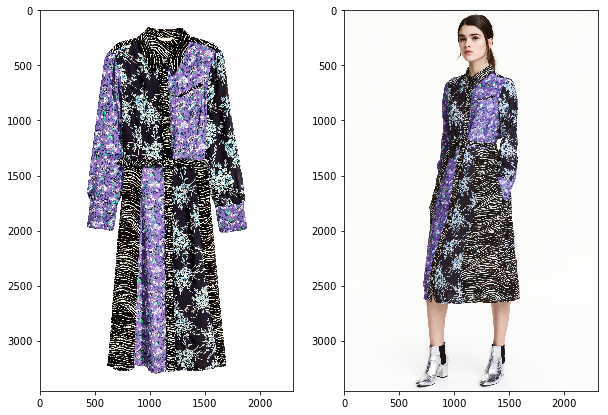

In [2]:
# some data is ill-formated, we dont want it
to_ignore_file = "to_ignore.txt"
db_path = 'db/robes/'

cat_by_id = dm.get_images_by_id(db_path+'cat/',dm.id_getter_cat,dm.id_select_cat,to_ignore_file)
quer_by_id = dm.get_images_by_id(db_path+'mod/',dm.id_getter_quer,dm.id_select_quer,to_ignore_file)

class_of_id, id_of_class = dm.get_id_class_correspondance(cat_by_id)
print("\nThe database contains "+str(len(cat_by_id))+" query/item pairs such as:\n\t"+str(cat_by_id[0])+"\n\t"+str(quer_by_id[0])+"\n")

id_img_ex = 114
img_cat_ex = dm.img_getter(cat_by_id[id_img_ex])
img_quer_ex = dm.img_getter(quer_by_id[id_img_ex])

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img_cat_ex)
plt.subplot(122)
plt.imshow(img_quer_ex)
plt.show()

## Queries Region Of Interest
We use a simple hand-crafted heuristic in order to get a ROI for any query image.

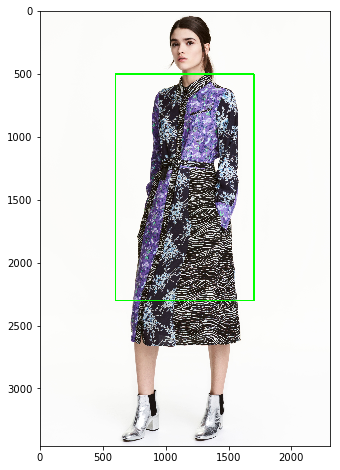

In [3]:
roi_query = (600,500,1100,1800)
img_quer_ex_roi = img_quer_ex.copy()
draw_rectangle(img_quer_ex_roi,roi_query,(0,255,0),thick=10)

plt.figure(figsize = (8,8))
plt.imshow(img_quer_ex_roi)
plt.show()

## Images Sub-Sampling
We are going to sample the ROI (or entire image) at fixed scale and strides.   
We call the sub images rectangle *crops*.    
We do it with squared sliding windows (rectangles at borders).

In [4]:
# returns the list with all the samples rect ('crops')
# img: image to crop from
# roi: rectangle to sample
# divide_by: divide minimum side by divide_by (integer)
# stride: will move in minimum_side / divide_by unit
def regular_sampling(img, roi, divide_by, stride):
    if not le_pt(stride,(1.,1.)):
        print("error: stride should be <= 1.")
        return []
    
    all_crops = []
    unit_square_sz = min(roi[2:])/divide_by
    
    x_range = np.arange(roi[0], roi[0]+roi[2],unit_square_sz*stride[0])
    y_range = np.arange(roi[1], roi[1]+roi[3],unit_square_sz*stride[1])
    
    # for integer redundancy
    seen_crops = {}
    
    for y in y_range:
        for x in x_range:
            integer_crop = (int(x),int(y),int(unit_square_sz),int(unit_square_sz))
            
            # get rid of out ranged ones
            if not valid_rect(roi,integer_crop):
                continue
            
            if integer_crop in seen_crops:
                print("warning: integer redundancy in crops")
            seen_crops[integer_crop] = True
            
            all_crops.append(integer_crop)
    return eat_it_all(all_crops,roi)

# the above function could leave a small percentage of the roi untouched
# this fixes it (not really optimally though)
def eat_it_all(crop_list, roi):
    max_x = max([crop[0] for crop in crop_list])
    max_y = max([crop[1] for crop in crop_list])
    
    right_bot = get_end_point(roi)
    
    new_list = []
    for x,y,w,h in crop_list:
        new_x,new_y,new_w,new_h=x,y,w,h
        if x == max_x and x+w < right_bot[0]:
            new_w = right_bot[0]-x
        if y == max_y and y+h < right_bot[1]:
            new_h = right_bot[1]-y
        new_list.append((new_x,new_y,new_w,new_h))
    return new_list

### Example

There are 77 crops on the catalogue image


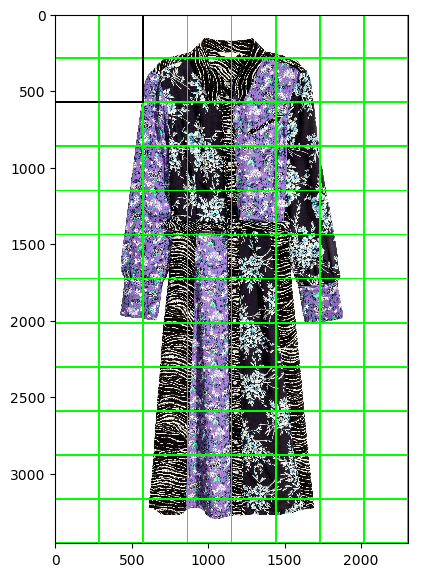

There are 84 crops on the query image


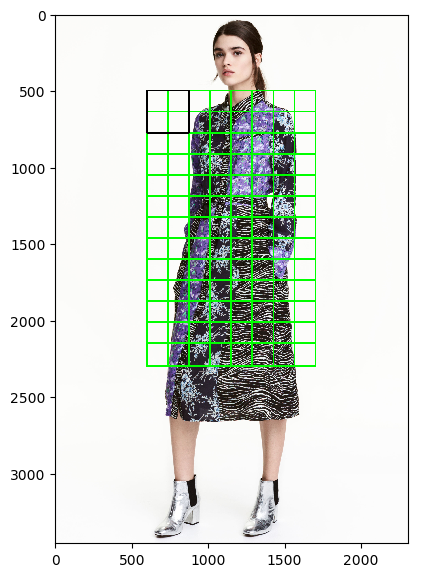

In [5]:
'''
    Plotting routine for our crops.
'''
def plot_img_samples(img,img_crops):
    fig, axes = plt.subplots(1, 1)
    fig.set_dpi(100)
    fig.set_size_inches((8,7))
    img_copy = img.copy()
    for (i,crop) in enumerate(img_crops):
        color = (255,0,0,50) if i%2 == 0 else (0,255,0,50)
        draw_rectangle(img_copy,crop,(0,255,0,50),thick=10)
    
    draw_rectangle(img_copy,img_crops[0],(0,0,0,50),thick=10)
    plt.imshow(img_copy)
    plt.show()
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)
    cv2.imwrite("ex_mod_win.jpg",img_copy)
    
cat_crops = regular_sampling(img_cat_ex,get_rect_img(img_cat_ex),4,(0.5,0.5))
img_cat_crops = [get_img_crop(img_cat_ex,crop) for crop in cat_crops]
print("There are", len(cat_crops), "crops on the catalogue image")
plot_img_samples(img_cat_ex,cat_crops)

quer_crops = regular_sampling(img_quer_ex,roi_query,4,(0.5,0.5))
img_quer_crops = [get_img_crop(img_quer_ex,crop) for crop in quer_crops]
print("There are", len(quer_crops), "crops on the query image")
plot_img_samples(img_quer_ex,quer_crops)

## Features Extraction
We use the incetionV3 model as a feature extractor.    
With the `inception` module, we use some code of [this](https://github.com/Hvass-Labs/TensorFlow-Tutorials) excellent github repo.

In [6]:
inception.maybe_download()
model = inception.Inception()

Data has apparently already been downloaded and unpacked.


In [6]:
'''
    This routine extracts all the features given an image and sub-images crops.
'''
def get_features_of_crops(img,crop_list):
    features_list = []
    for x,y,w,h in crop_list:
        img_crop = img[y:y+h,x:x+w,:]
        features = model.transfer_values(image=img_crop)
        features_list.append(features)
    return features_list

'''
    This routine creates a dictionary with the crops features associated to each garment.
    cat: a boolean that specifies whether we are working on the catalogue or the 
    queries for ROI purpose.
'''
def compute_DCNN_features(cat=True):
    to_return = {}
    
    img_set = cat_by_id
    if not cat:
        img_set = quer_by_id
    
    for (image_id,image_path) in img_set.items():
        img = dm.img_getter(image_path)
        
        img_roi = get_rect_img(img)#take all the img by default
        if not cat:
            img_roi = roi_query
        
        img_crops = regular_sampling(img,img_roi,4,(0.5,0.5))
        
        features = get_features_of_crops(img,img_crops)
        to_return[image_id] = np.array(features)

    return to_return

### Features Extraction
We collect the features of each of the crop on each catalogue and query garments. Refer to Results_DCNNs.ipynb for computation time information.

In [7]:
cat_DCNN_per_id = cache.cache("dumps/cat_DCNN_per_id.dump",compute_DCNN_features)
quer_DCNN_per_id = cache.cache("dumps/quer_DCNN_per_id.dump",compute_DCNN_features,cat=False)

- Data loaded from cache-file: dumps/cat_DCNN_per_id.dump
- Data loaded from cache-file: dumps/quer_DCNN_per_id.dump


## Standard SOM Training and Visualization
### SOM routines

In [8]:
'''
    Routines to aggregate data per bmu on the SOM.
'''
def get_id_per_bmu(som):
    to_return = [[] for i in range(som.shape[0]*som.shape[1])]
    for i,d in enumerate(som.data):
        bmu = som.find_bmu(d)
        to_return[bmu[0]*som.shape[1]+bmu[1]].append(i)
    return to_return
def get_som_concentration(som,id_per_bmu):
    return np.array(list(map(len,id_per_bmu))).reshape(som.shape[:2]).astype(int)

In [9]:
'''
    Routine to plot the SOM and its BMU data on a grid.
'''
def plot_som_data_grid(som,size_square,id_per_bmu,imgs):
    fig = plt.figure(figsize=(15, 15))

    # gridspec inside gridspec
    outer_grid = gridspec.GridSpec(som.shape[0], som.shape[1], wspace=0.0, hspace=0.0)
    for i in range(som.shape[0]*som.shape[1]):
        inner_grid = gridspec.GridSpecFromSubplotSpec(size_square, size_square, subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)

        for j in range(size_square*size_square):
            img = np.ones(imgs[0].shape)
            if j < len(id_per_bmu[i]):
                i_img = id_per_bmu[i][j]
                img = imgs[i_img].copy()
                draw_rectangle(img,get_rect_img(img),(0,255,0),20)
                
            ax = plt.Subplot(fig, inner_grid[j])
            
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

    all_axes = fig.get_axes()
        #show only the outside spines
    
    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
        if ax.is_first_row():
            ax.spines['top'].set_visible(True)
        if ax.is_last_row():
            ax.spines['bottom'].set_visible(True)
        if ax.is_first_col():
            ax.spines['left'].set_visible(True)
        if ax.is_last_col():
            ax.spines['right'].set_visible(True)

    plt.show()

### Catalogue Image
#### Training

In [10]:
%%time
cat_som = SOM(8,8,2048)
cat_som.train(cat_DCNN_per_id[id_img_ex],sigma0=4,L0=1,lam=200)
cat_som_id_per_bmu = get_id_per_bmu(cat_som)
som_conc = get_som_concentration(cat_som,cat_som_id_per_bmu)
for (i,l) in enumerate(som_conc):
    print(i,l)

final t: 416
0 [ 3  1  1  0  3  1  0 10]
1 [1 0 0 1 1 1 1 0]
2 [1 0 0 1 2 0 0 0]
3 [1 1 2 1 0 2 0 1]
4 [0 0 0 0 2 1 2 1]
5 [3 1 3 1 1 1 0 1]
6 [0 0 1 3 0 1 0 0]
7 [3 1 2 1 6 0 2 4]
CPU times: user 1.44 s, sys: 4.39 ms, total: 1.45 s
Wall time: 1.45 s


#### Visualizing

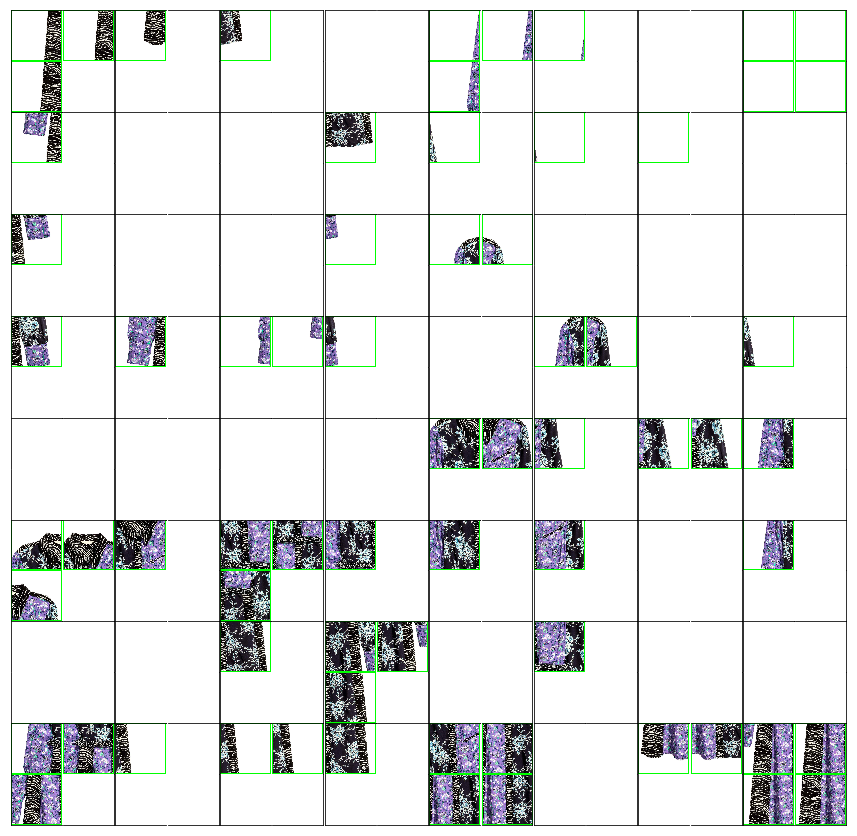

In [11]:
plot_som_data_grid(cat_som,2,cat_som_id_per_bmu,img_cat_crops)

### Query Image
#### Training

In [12]:
%%time
quer_som = SOM(8,8,2048)
quer_som.train(quer_DCNN_per_id[id_img_ex],sigma0=4,L0=1,lam=200)
quer_som_id_per_bmu = get_id_per_bmu(quer_som)
som_conc = get_som_concentration(quer_som,quer_som_id_per_bmu)
for (i,l) in enumerate(som_conc):
    print(i,l)

final t: 416
0 [3 2 1 1 2 2 4 2]
1 [2 1 1 0 2 1 1 0]
2 [2 0 1 2 0 3 0 2]
3 [0 0 3 4 0 1 1 0]
4 [2 2 1 0 3 1 1 2]
5 [4 1 0 1 1 2 1 0]
6 [1 2 1 1 0 0 0 1]
7 [1 2 1 2 2 0 0 4]
CPU times: user 1.31 s, sys: 1.46 ms, total: 1.31 s
Wall time: 1.31 s


#### Visualizing

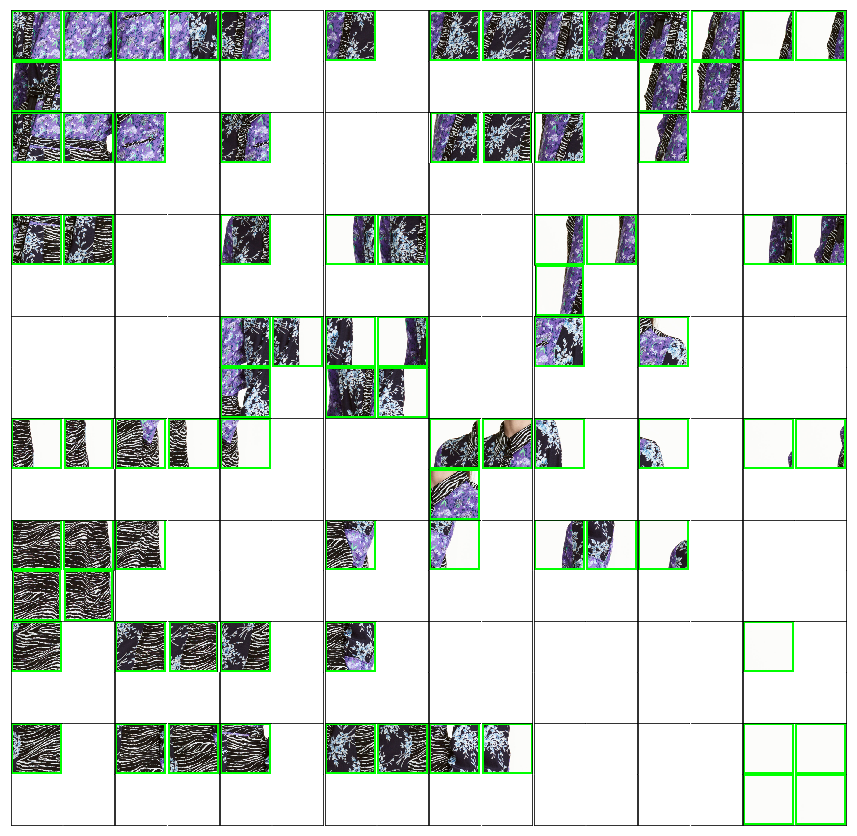

In [13]:
plot_som_data_grid(quer_som,2,quer_som_id_per_bmu,img_quer_crops)

## Emergent SOM Training and Visualization
### ESOM routines

In [14]:
'''
    Routines to compute the U matrix.
'''
def is_valid_unit(som,unit):
    y,x = unit
    return y >= 0 and y < som.shape[0] and x >= 0 and x < som.shape[1]
def one_adj_mean_dist(som,unit):
    y,x = unit
    dirs = [[0,1],[1,0],[0,-1],[-1,0]]
    dists = []
    for dir_ in dirs:
        y_n,x_n = y+dir_[0],x+dir_[0]
        if is_valid_unit(som,(y_n,x_n)):
            dists.append(np.linalg.norm(som.som[unit]-som.som[(y_n,x_n)]))
    return np.array(dists).sum()
def get_one_adj_U_mat(som):
    U_mat = np.zeros(som.shape[:2])
    for y in range(som.shape[0]):
        for x in range(som.shape[1]):
            U_mat[(y,x)] = one_adj_mean_dist(som,(y,x))
    return U_mat

In [15]:
'''
    Get the list of all the bmus coordinates on a SOM.
'''
def get_bmus_coord(som):
    bmus = []
    bmu_locations_x,bmu_locations_y = [],[]
    for d in som.data:
        bmu = som.find_bmu(d)
        
        bmus.append(bmu)
        
        bmu_locations_x.append(bmu[1])
        bmu_locations_y.append(bmu[0])
        
    return bmus,bmu_locations_x,bmu_locations_y

In [24]:
def id_of_coord(w,bmu):
    y,x = bmu
    return y*w+x
def get_annotation_image(som,imgs,id_per_bmus,bmu):
    id_in_tab = id_of_coord(som.shape[1],bmu)
    id_of_image = id_per_bmus[id_in_tab][0]
    return imgs[id_of_image]
def plot_annotated_esom(som,id_per_bmu,imgs,xybox_off=(30.,30.),resize_factor=0.07):
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111)
    one_adj_U_mat = get_one_adj_U_mat(som)
    im = plt.imshow(one_adj_U_mat, interpolation='bilinear')
    img = ax.contourf(one_adj_U_mat)

    bmus,bmu_locations_x,bmu_locations_y  = get_bmus_coord(som)
    
    for bmu in bmus:
        img_annot = get_annotation_image(som,imgs,id_per_bmu,bmu)
        img_annot = scipy.misc.imresize(img_annot,resize_factor)
        imm = OffsetImage(img_annot, zoom=1)
        imm.image.axes = ax
        z = 1.0
        if bmu[1] <= 25:
            z = -1.0
        xybox = (z*xybox_off[0],xybox_off[1])
        ab = AnnotationBbox(imm, bmu[::-1],
                        xybox=(z*30., 30.),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.3,
                         arrowprops=dict(arrowstyle="->"))

        ax.add_artist(ab)
    ax.scatter(bmu_locations_x,bmu_locations_y, marker='o', color='red')
    fig.colorbar(im)
    plt.show()

### Catalogue Image
#### Training

In [16]:
%%time
cat_esom = SOM(50,50,2048)
cat_esom.train(cat_DCNN_per_id[id_img_ex],sigma0=24,L0=1,lam=200)
cat_esom_id_per_bmu = get_id_per_bmu(cat_esom)

final t: 775
CPU times: user 1min 34s, sys: 108 µs, total: 1min 34s
Wall time: 1min 34s


#### Visualizing

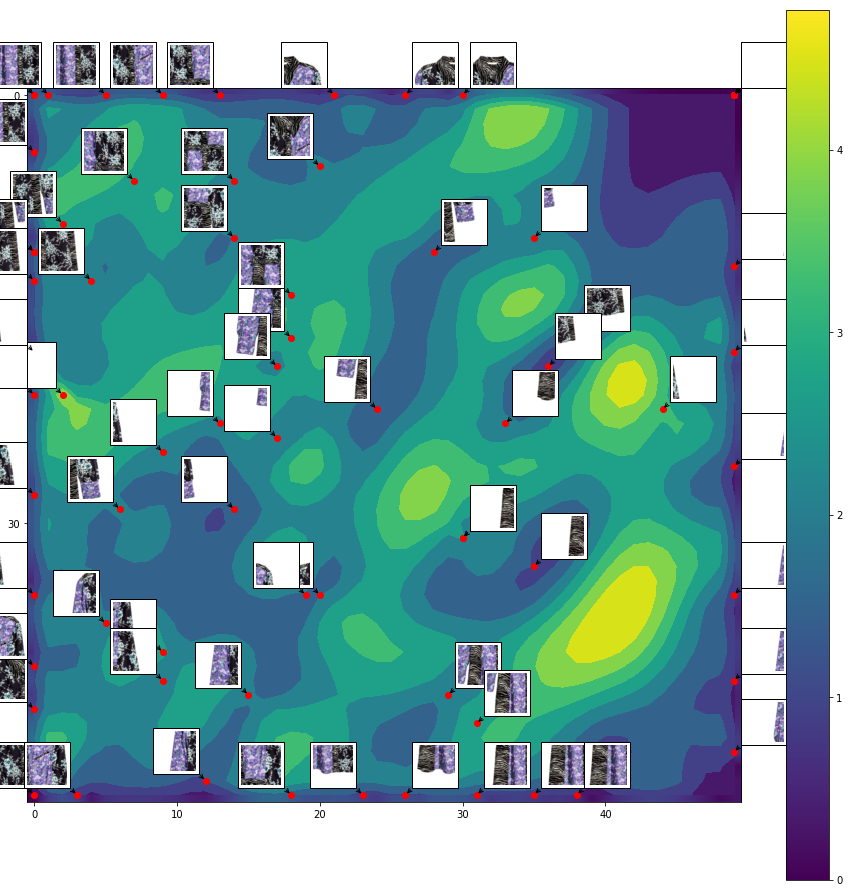

In [25]:
plot_annotated_esom(cat_esom,cat_esom_id_per_bmu,img_cat_crops)

### Query Image
#### Training

In [23]:
%%time
quer_esom = SOM(50,50,2048)
quer_esom.train(quer_DCNN_per_id[id_img_ex],sigma0=24,L0=1,lam=200)
quer_esom_id_per_bmu = get_id_per_bmu(quer_esom)

final t: 775
CPU times: user 1min 35s, sys: 1.04 ms, total: 1min 35s
Wall time: 1min 35s


#### Visualizing

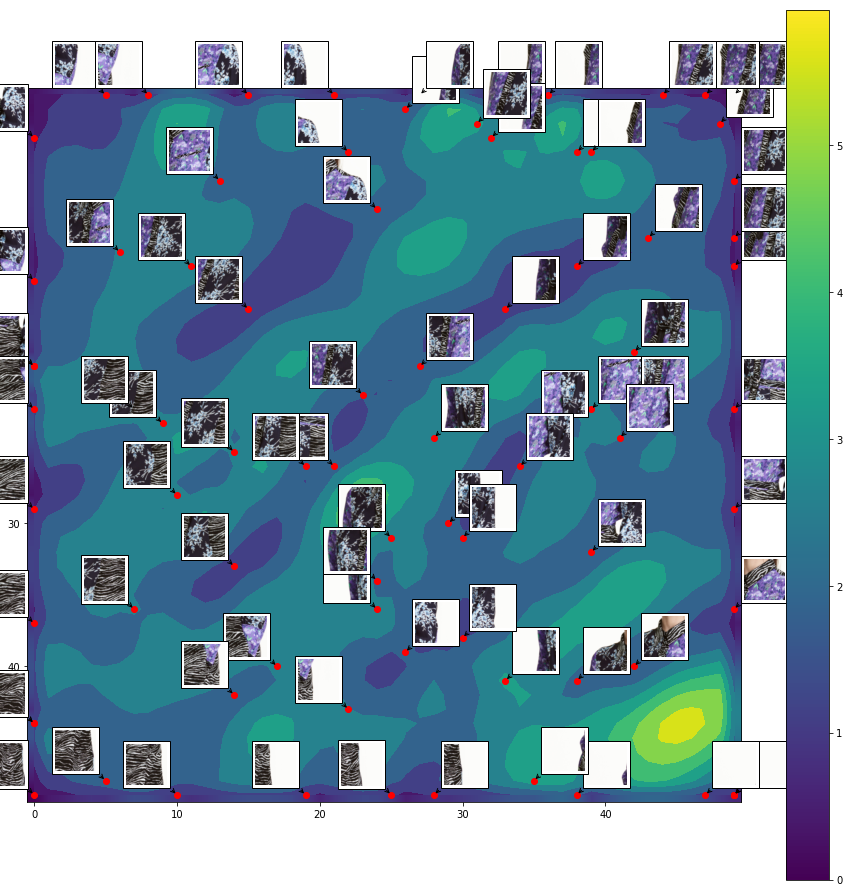

In [27]:
plot_annotated_esom(quer_esom,quer_esom_id_per_bmu,img_quer_crops,xybox_off=(20.,20.),resize_factor=0.15)